# Notebook 05 : Optimisation du Seuil de Décision

**Objectif :** Déterminer le seuil de décision optimal pour le système de scoring crédit en tenant compte des coûts métier.

**Approche :** Fonction de coût métier simplifiée avec ratio FN:FP de 10:1, reflétant le fait qu'un défaut de paiement coûte environ 10 fois plus cher qu'un refus de crédit.

In [1]:
# ============================================================================
# IMPORTS ET CONFIGURATION
# ============================================================================
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

# Chemins
ARTIFACTS_DIR = Path('./artifacts')
FIGURES_DIR = Path('./figures')
FIGURES_DIR.mkdir(exist_ok=True, parents=True)

print("Configuration terminée")

Configuration terminée


## 1. Chargement des Données et du Modèle

In [2]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================
print("="*80)
print("CHARGEMENT DES DONNEES")
print("="*80)

# Charger les données de validation
X_valid = joblib.load(ARTIFACTS_DIR / 'X_valid_processed.joblib')
y_valid = joblib.load(ARTIFACTS_DIR / 'y_valid.joblib')

print(f"\nX_valid : {X_valid.shape}")
print(f"y_valid : {y_valid.shape}")

# Distribution des classes
print(f"\nDistribution des classes :")
print(f"  Classe 0 (pas de défaut) : {(y_valid==0).sum():,} ({(y_valid==0).mean():.1%})")
print(f"  Classe 1 (défaut)        : {(y_valid==1).sum():,} ({(y_valid==1).mean():.1%})")

# Charger le modèle
model = joblib.load(ARTIFACTS_DIR / 'meilleur_modele.joblib')
print(f"\nModèle chargé : {type(model).__name__}")

print("\n" + "="*80)
print("DONNEES CHARGEES AVEC SUCCES")
print("="*80)

CHARGEMENT DES DONNEES

X_valid : (61502, 804)
y_valid : (61502,)

Distribution des classes :
  Classe 0 (pas de défaut) : 56,537 (91.9%)
  Classe 1 (défaut)        : 4,965 (8.1%)

Modèle chargé : LGBMClassifier

DONNEES CHARGEES AVEC SUCCES


## 2. Génération des Probabilités

In [3]:
# ============================================================================
# PRÉDICTIONS DE PROBABILITÉ
# ============================================================================
print("Génération des probabilités de défaut...")

# Prédire les probabilités
proba_valid = model.predict_proba(X_valid)[:, 1]

print(f"\nProbabilités générées : {len(proba_valid):,}")
print(f"\nStatistiques des probabilités :")
print(f"  Minimum : {proba_valid.min():.4f}")
print(f"  Maximum : {proba_valid.max():.4f}")
print(f"  Moyenne : {proba_valid.mean():.4f}")
print(f"  Médiane : {np.median(proba_valid):.4f}")

# Score ROC-AUC
roc_auc = roc_auc_score(y_valid, proba_valid)
print(f"\nROC-AUC : {roc_auc:.4f}")

Génération des probabilités de défaut...

Probabilités générées : 61,502

Statistiques des probabilités :
  Minimum : 0.0030
  Maximum : 0.9931
  Moyenne : 0.3070
  Médiane : 0.2475

ROC-AUC : 0.6881


## 3. Fonction de Coût Métier

Nous utilisons une fonction de coût simplifiée basée sur les coûts relatifs :
- **Faux Positif (FP)** : Refuser un bon client = 1 unité de coût
- **Faux Négatif (FN)** : Accepter un mauvais client = 10 unités de coût

Le ratio 10:1 reflète que les pertes liées aux défauts de paiement sont environ 10 fois plus importantes que les coûts liés aux refus abusifs.

In [4]:
# ============================================================================
# FONCTION DE COUT METIER
# ============================================================================

def calculer_cout_metier(y_true, y_pred, verbose=False):
    """
    Calcule le coût métier avec fonction simplifiée.
    
    Coûts relatifs :
    - FP (refuser bon client) : 1 unité
    - FN (accepter mauvais client) : 10 unités
    
    Le score est normalisé entre 0 (pire) et 1 (meilleur).
    
    Parameters:
    -----------
    y_true : array-like
        Vraies étiquettes
    y_pred : array-like
        Prédictions binaires
    verbose : bool
        Afficher les détails
    
    Returns:
    --------
    dict : Dictionnaire avec métriques et coût
    """
    # Coûts fixes
    COUT_FP = 1
    COUT_FN = 10
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Coût total
    cout_total = COUT_FP * fp + COUT_FN * fn
    
    # Normalisation par coût maximum possible
    n_pos = (y_true == 1).sum()
    n_neg = (y_true == 0).sum()
    cout_max = COUT_FP * n_neg + COUT_FN * n_pos
    
    # Score normalisé (1 = meilleur, 0 = pire)
    score = 1 - (cout_total / cout_max)
    
    # Métriques business
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    taux_approbation = (tn + fn) / len(y_true)
    
    resultats = {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp),
        'cout_total': cout_total,
        'cout_max': cout_max,
        'score': score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'taux_approbation': taux_approbation
    }
    
    if verbose:
        print(f"\nMatrice de confusion :")
        print(f"  TN : {tn:,} | FP : {fp:,}")
        print(f"  FN : {fn:,} | TP : {tp:,}")
        print(f"\nCoût total : {cout_total:,} / {cout_max:,}")
        print(f"Score normalisé : {score:.4f}")
    
    return resultats

print("Fonction de coût métier définie")

Fonction de coût métier définie


## 4. Test avec le Seuil par Défaut (0.5)

In [5]:
# ============================================================================
# TEST AVEC SEUIL PAR DÉFAUT
# ============================================================================
print("="*80)
print("TEST AVEC SEUIL PAR DEFAUT (0.5)")
print("="*80)

# Prédictions avec seuil 0.5
y_pred_default = (proba_valid >= 0.5).astype(int)

# Calculer le coût
res_default = calculer_cout_metier(y_valid, y_pred_default, verbose=True)

print(f"\nMétriques :")
print(f"  Précision : {res_default['precision']:.2%}")
print(f"  Recall    : {res_default['recall']:.2%}")
print(f"  F1-Score  : {res_default['f1']:.2%}")
print(f"  Taux approbation : {res_default['taux_approbation']:.2%}")

TEST AVEC SEUIL PAR DEFAUT (0.5)

Matrice de confusion :
  TN : 45,358 | FP : 11,179
  FN : 2,863 | TP : 2,102

Coût total : 39,809 / 106,187
Score normalisé : 0.6251

Métriques :
  Précision : 15.83%
  Recall    : 42.34%
  F1-Score  : 23.04%
  Taux approbation : 78.41%


## 5. Optimisation du Seuil

Nous testons 101 seuils entre 0 et 1 pour trouver celui qui minimise le coût métier.

In [6]:
# ============================================================================
# BALAYAGE DES SEUILS
# ============================================================================
print("="*80)
print("OPTIMISATION DU SEUIL DE DECISION")
print("="*80)

# Tester 101 seuils
seuils = np.linspace(0, 1, 101)
resultats = []

print(f"\nTest de {len(seuils)} seuils...")

for seuil in seuils:
    # Prédictions avec ce seuil
    y_pred = (proba_valid >= seuil).astype(int)
    
    # Calculer le coût
    res = calculer_cout_metier(y_valid, y_pred)
    res['seuil'] = seuil
    
    resultats.append(res)

# Créer DataFrame
df_seuils = pd.DataFrame(resultats)

# Trouver le seuil optimal (score maximum)
idx_optimal = df_seuils['score'].idxmax()
seuil_optimal = df_seuils.loc[idx_optimal, 'seuil']
score_optimal = df_seuils.loc[idx_optimal, 'score']

# Comparer avec défaut
score_default = df_seuils[df_seuils['seuil'] == 0.5]['score'].values[0]
amelioration = (score_optimal - score_default) / score_default * 100

print(f"\nAnalyse terminée")
print(f"\n" + "="*80)
print(" RESULTATS DE L'OPTIMISATION")
print("="*80)

print(f"\nSeuil OPTIMAL : {seuil_optimal:.3f}")
print(f"Score optimal : {score_optimal:.4f}")

print(f"\nSeuil par DÉFAUT : 0.500")
print(f"Score défaut : {score_default:.4f}")

print(f"\nAMÉLIORATION : {amelioration:+.2f}%")

OPTIMISATION DU SEUIL DE DECISION

Test de 101 seuils...

Analyse terminée

 RESULTATS DE L'OPTIMISATION

Seuil OPTIMAL : 0.370
Score optimal : 0.6387

Seuil par DÉFAUT : 0.500
Score défaut : 0.6251

AMÉLIORATION : +2.18%


## 6. Analyse Détaillée du Seuil Optimal

In [7]:
# ============================================================================
# DÉTAILS DU SEUIL OPTIMAL
# ============================================================================
print("="*80)
print(" ANALYSE DÉTAILLÉE DU SEUIL OPTIMAL")
print("="*80)

# Prédictions avec seuil optimal
y_pred_optimal = (proba_valid >= seuil_optimal).astype(int)
res_optimal = calculer_cout_metier(y_valid, y_pred_optimal)

print(f"\nSeuil optimal : {seuil_optimal:.3f}")
print(f"\n1. MATRICE DE CONFUSION :")
print(f"   Vrais Négatifs (TN)  : {res_optimal['tn']:>7,} ({res_optimal['tn']/len(y_valid)*100:>5.1f}%)")
print(f"   Faux Positifs (FP)   : {res_optimal['fp']:>7,} ({res_optimal['fp']/len(y_valid)*100:>5.1f}%)")
print(f"   Faux Négatifs (FN)   : {res_optimal['fn']:>7,} ({res_optimal['fn']/len(y_valid)*100:>5.1f}%)")
print(f"   Vrais Positifs (TP)  : {res_optimal['tp']:>7,} ({res_optimal['tp']/len(y_valid)*100:>5.1f}%)")

print(f"\n2. MÉTRIQUES BUSINESS :")
print(f"   Précision            : {res_optimal['precision']:>7.2%}")
print(f"   Rappel (Recall)      : {res_optimal['recall']:>7.2%}")
print(f"   F1-Score             : {res_optimal['f1']:>7.2%}")
print(f"   Taux d'approbation   : {res_optimal['taux_approbation']:>7.2%}")

print(f"\n3. FONCTION DE COÛT :")
print(f"   Coût FP (unitaire)   : 1")
print(f"   Coût FN (unitaire)   : 10")
print(f"   Ratio FN:FP          : 10:1")
print(f"   Coût total           : {res_optimal['cout_total']:,}")
print(f"   Coût maximum         : {res_optimal['cout_max']:,}")
print(f"   Score normalisé      : {res_optimal['score']:.4f}")

# Comparaison avec défaut
print(f"\n" + "="*80)
print(" COMPARAISON AVEC SEUIL PAR DÉFAUT")
print("="*80)

res_default = calculer_cout_metier(y_valid, y_pred_default)

print(f"\n{'Métrique':<25} {'Seuil 0.5':>12} {'Seuil Optimal':>15} {'Delta':>12}")
print("-" * 70)
print(f"{'Faux Négatifs (FN)':<25} {res_default['fn']:>12,} {res_optimal['fn']:>15,} {res_optimal['fn']-res_default['fn']:>12,}")
print(f"{'Faux Positifs (FP)':<25} {res_default['fp']:>12,} {res_optimal['fp']:>15,} {res_optimal['fp']-res_default['fp']:>12,}")
print(f"{'Coût total':<25} {res_default['cout_total']:>12,} {res_optimal['cout_total']:>15,} {res_optimal['cout_total']-res_default['cout_total']:>12,}")
print(f"{'Score':<25} {res_default['score']:>12.4f} {res_optimal['score']:>15.4f} {res_optimal['score']-res_default['score']:>12.4f}")
print(f"{'Recall':<25} {res_default['recall']:>12.2%} {res_optimal['recall']:>15.2%} {res_optimal['recall']-res_default['recall']:>12.2%}")
print(f"{'Taux approbation':<25} {res_default['taux_approbation']:>12.2%} {res_optimal['taux_approbation']:>15.2%} {res_optimal['taux_approbation']-res_default['taux_approbation']:>12.2%}")

 ANALYSE DÉTAILLÉE DU SEUIL OPTIMAL

Seuil optimal : 0.370

1. MATRICE DE CONFUSION :
   Vrais Négatifs (TN)  :  38,533 ( 62.7%)
   Faux Positifs (FP)   :  18,004 ( 29.3%)
   Faux Négatifs (FN)   :   2,036 (  3.3%)
   Vrais Positifs (TP)  :   2,929 (  4.8%)

2. MÉTRIQUES BUSINESS :
   Précision            :  13.99%
   Rappel (Recall)      :  58.99%
   F1-Score             :  22.62%
   Taux d'approbation   :  65.96%

3. FONCTION DE COÛT :
   Coût FP (unitaire)   : 1
   Coût FN (unitaire)   : 10
   Ratio FN:FP          : 10:1
   Coût total           : 38,364
   Coût maximum         : 106,187
   Score normalisé      : 0.6387

 COMPARAISON AVEC SEUIL PAR DÉFAUT

Métrique                     Seuil 0.5   Seuil Optimal        Delta
----------------------------------------------------------------------
Faux Négatifs (FN)               2,863           2,036         -827
Faux Positifs (FP)              11,179          18,004        6,825
Coût total                      39,809          38,364    

## 7. Visualisations

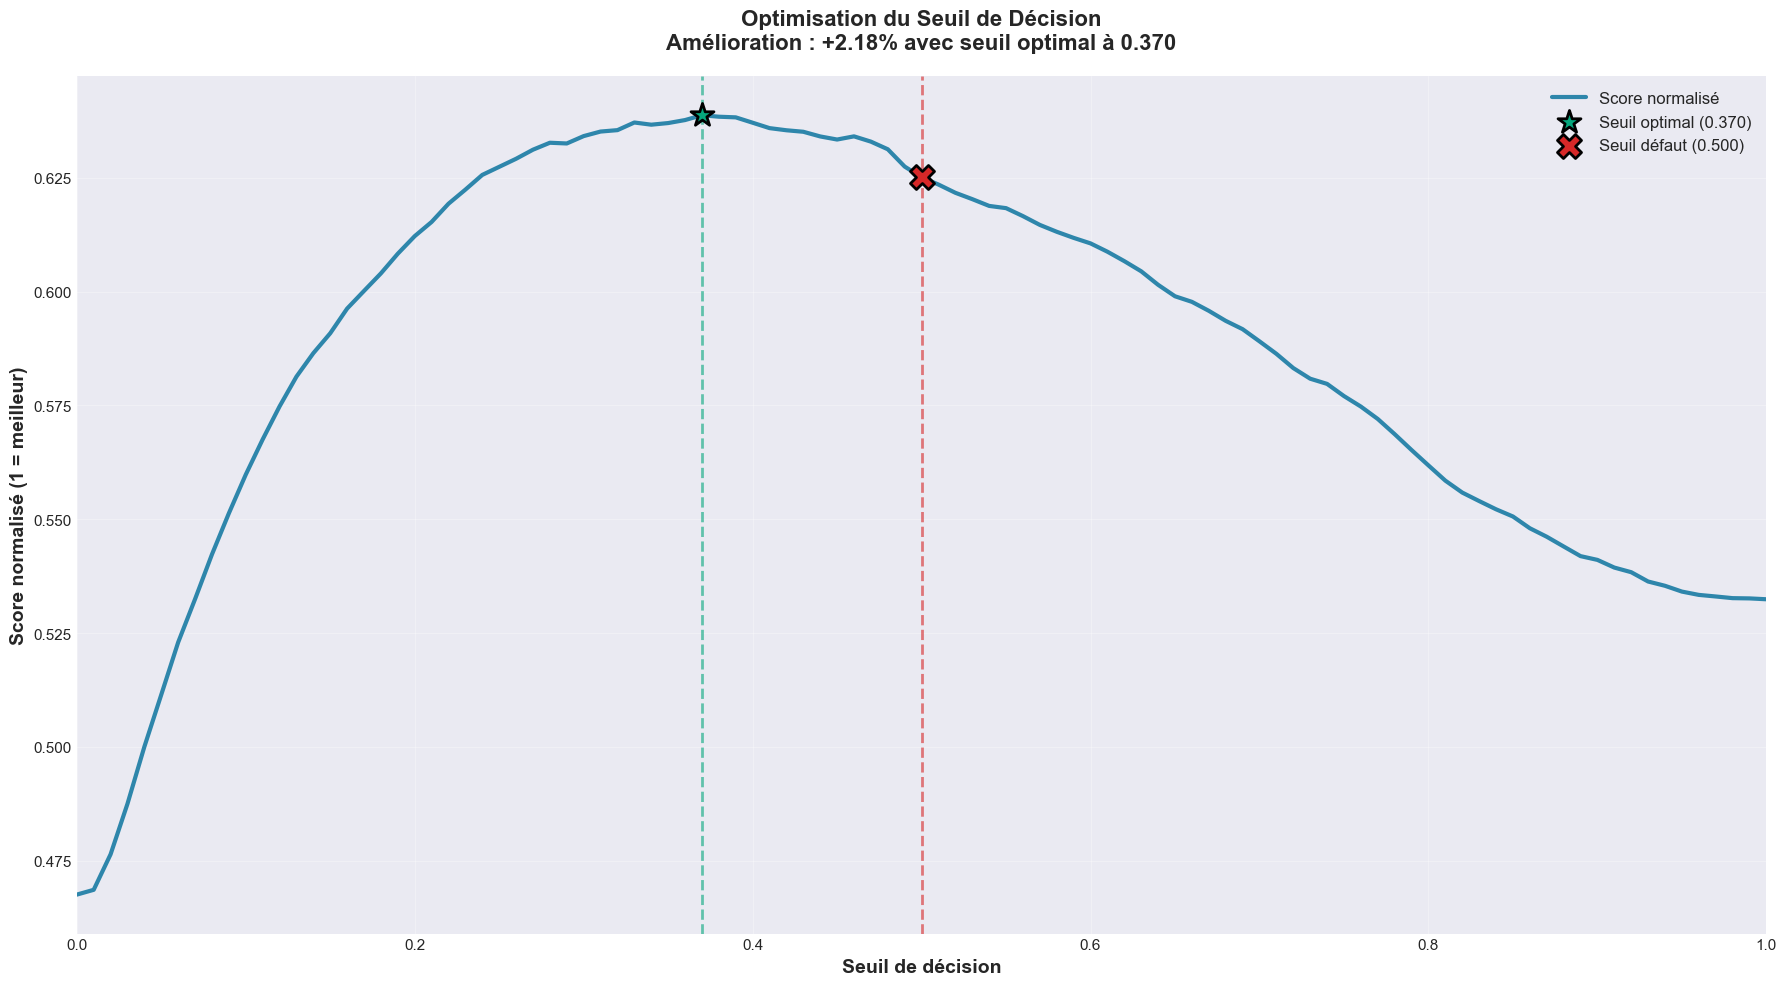

Figure sauvegardée : nb05_optimisation_seuil.png


In [8]:
# ============================================================================
# VISUALISATION 1 : COURBE D'OPTIMISATION
# ============================================================================

fig, ax = plt.subplots(figsize=(18, 10))

# Tracer le score en fonction du seuil
ax.plot(df_seuils['seuil'], df_seuils['score'], 
        linewidth=3, color='#2E86AB', label='Score normalisé')

# Marquer le seuil optimal
ax.scatter([seuil_optimal], [score_optimal], 
           s=300, color='#06A77D', marker='*', 
           label=f'Seuil optimal ({seuil_optimal:.3f})', 
           zorder=5, edgecolors='black', linewidths=2)

# Marquer le seuil par défaut
ax.scatter([0.5], [score_default], 
           s=300, color='#D62828', marker='X', 
           label=f'Seuil défaut (0.500)', 
           zorder=5, edgecolors='black', linewidths=2)

# Lignes verticales
ax.axvline(seuil_optimal, color='#06A77D', linestyle='--', alpha=0.6, linewidth=2)
ax.axvline(0.5, color='#D62828', linestyle='--', alpha=0.6, linewidth=2)

# Labels et titre
ax.set_xlabel('Seuil de décision', fontsize=14, fontweight='bold')
ax.set_ylabel('Score normalisé (1 = meilleur)', fontsize=14, fontweight='bold')
ax.set_title(f'Optimisation du Seuil de Décision\nAmélioration : {amelioration:+.2f}% avec seuil optimal à {seuil_optimal:.3f}', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'nb05_optimisation_seuil.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : nb05_optimisation_seuil.png")

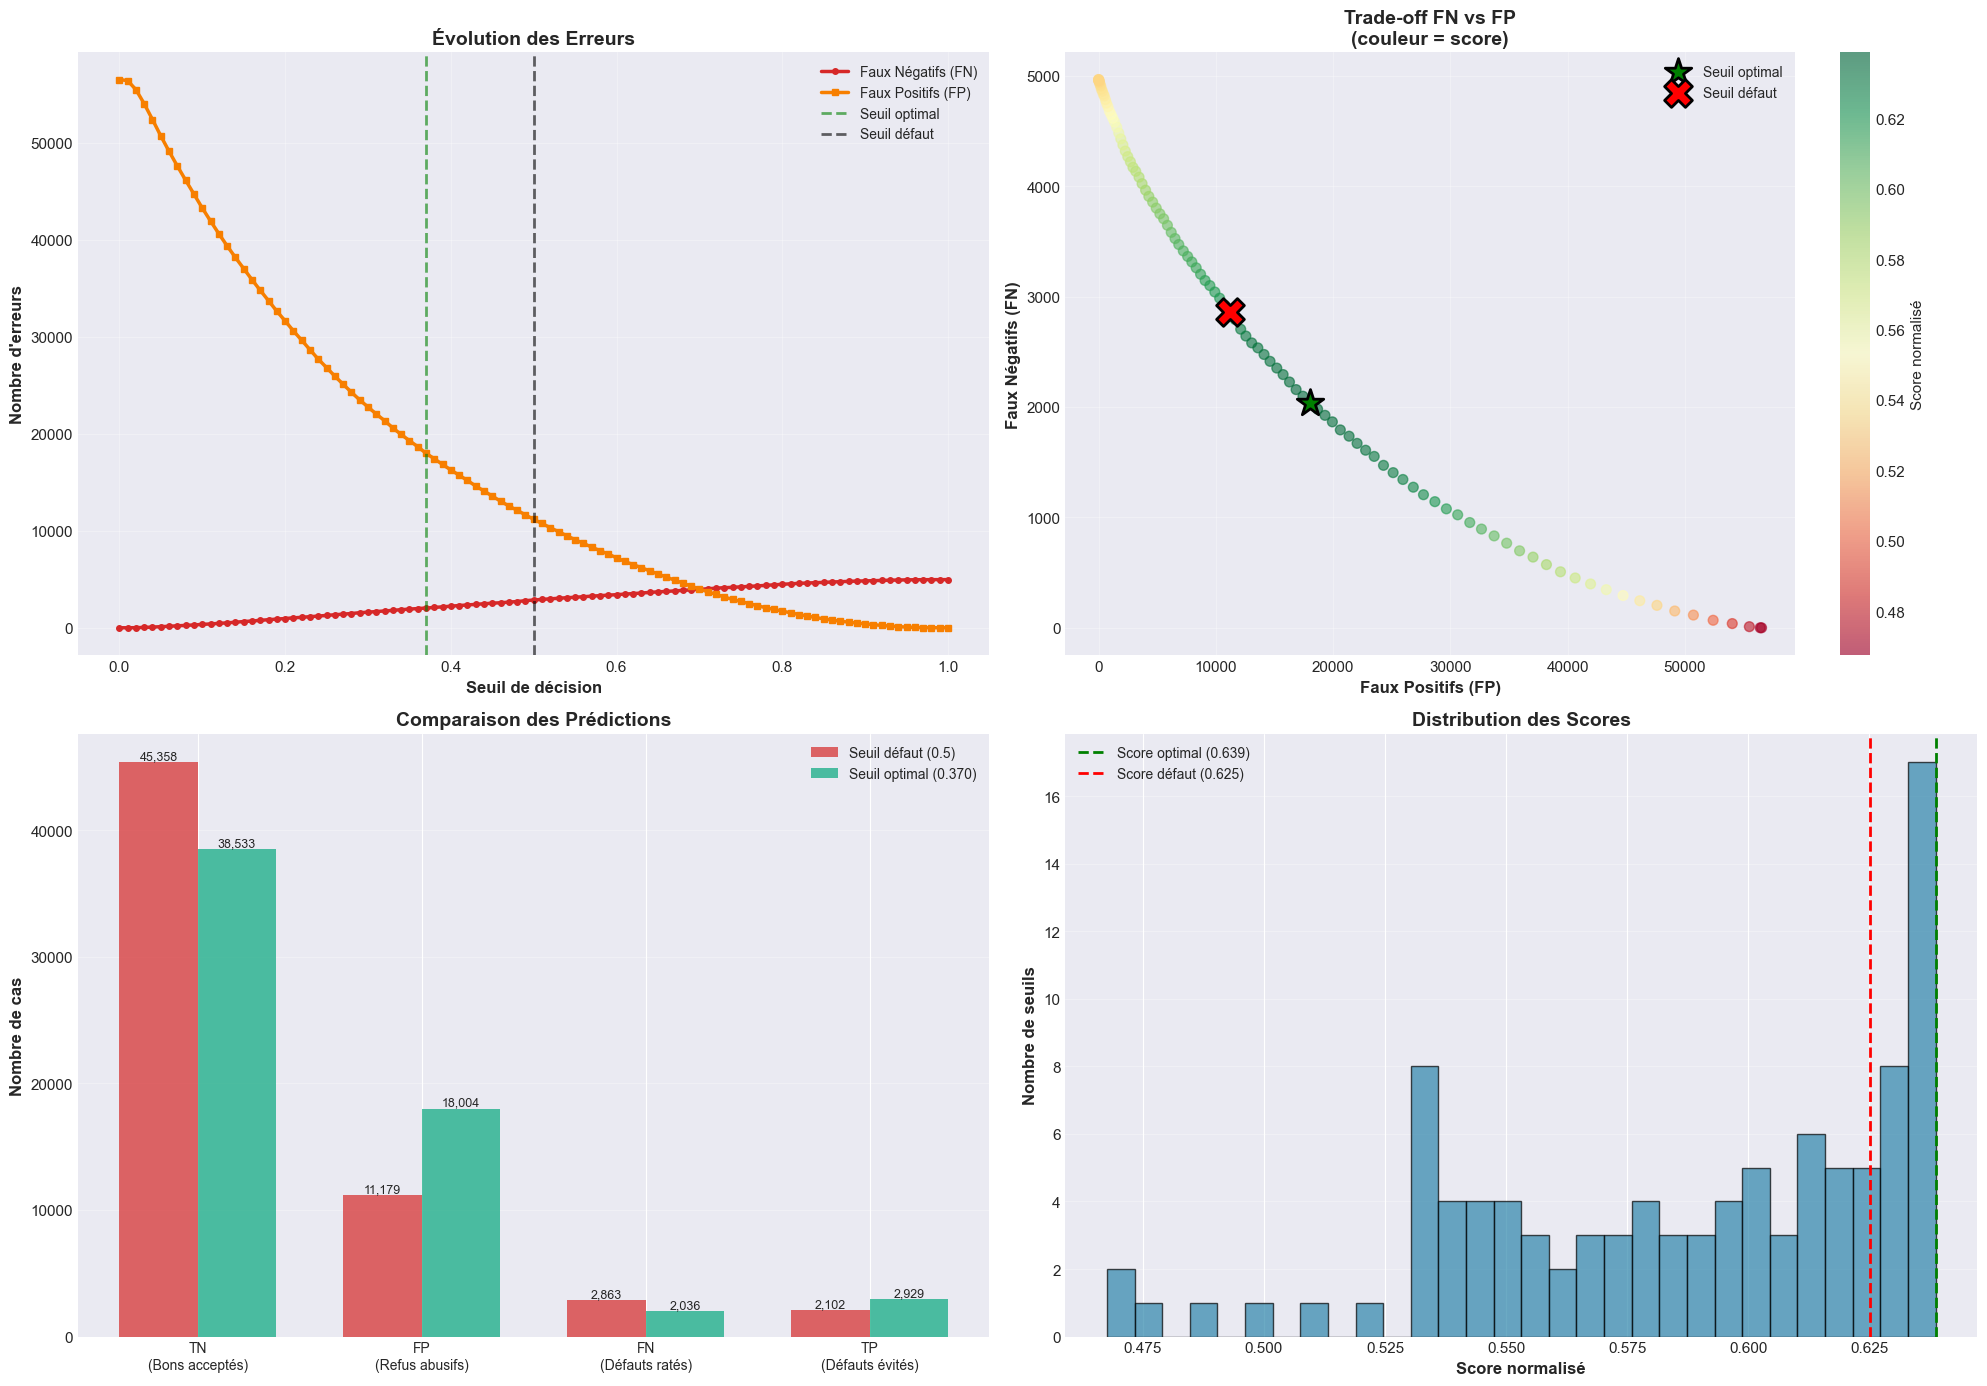

Figure sauvegardée : nb05_analyse_erreurs.png


In [9]:
# ============================================================================
# VISUALISATION 2 : ÉVOLUTION DES ERREURS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 1. Évolution FN et FP
ax1 = axes[0, 0]
ax1.plot(df_seuils['seuil'], df_seuils['fn'], 
         linewidth=2.5, color='#D62828', label='Faux Négatifs (FN)', marker='o', markersize=4)
ax1.plot(df_seuils['seuil'], df_seuils['fp'], 
         linewidth=2.5, color='#F77F00', label='Faux Positifs (FP)', marker='s', markersize=4)
ax1.axvline(seuil_optimal, color='green', linestyle='--', alpha=0.6, label='Seuil optimal', linewidth=2)
ax1.axvline(0.5, color='black', linestyle='--', alpha=0.6, label='Seuil défaut', linewidth=2)
ax1.set_xlabel('Seuil de décision', fontweight='bold', fontsize=12)
ax1.set_ylabel('Nombre d\'erreurs', fontweight='bold', fontsize=12)
ax1.set_title('Évolution des Erreurs', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(alpha=0.3)

# 2. Trade-off FN vs FP
ax2 = axes[0, 1]
scatter = ax2.scatter(df_seuils['fp'], df_seuils['fn'], 
                      c=df_seuils['score'], cmap='RdYlGn', s=50, alpha=0.6)
ax2.scatter(res_optimal['fp'], res_optimal['fn'], 
            s=400, color='green', marker='*', 
            label='Seuil optimal', zorder=5, edgecolors='black', linewidths=2)
ax2.scatter(res_default['fp'], res_default['fn'], 
            s=400, color='red', marker='X', 
            label='Seuil défaut', zorder=5, edgecolors='black', linewidths=2)
ax2.set_xlabel('Faux Positifs (FP)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Faux Négatifs (FN)', fontweight='bold', fontsize=12)
ax2.set_title('Trade-off FN vs FP\n(couleur = score)', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Score normalisé')

# 3. Comparaison des catégories
ax3 = axes[1, 0]
categories = ['TN\n(Bons acceptés)', 'FP\n(Refus abusifs)', 'FN\n(Défauts ratés)', 'TP\n(Défauts évités)']
valeurs_optimal = [res_optimal['tn'], res_optimal['fp'], res_optimal['fn'], res_optimal['tp']]
valeurs_default = [res_default['tn'], res_default['fp'], res_default['fn'], res_default['tp']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax3.bar(x - width/2, valeurs_default, width, label='Seuil défaut (0.5)', color='#D62828', alpha=0.7)
bars2 = ax3.bar(x + width/2, valeurs_optimal, width, label=f'Seuil optimal ({seuil_optimal:.3f})', color='#06A77D', alpha=0.7)

ax3.set_ylabel('Nombre de cas', fontweight='bold', fontsize=12)
ax3.set_title('Comparaison des Prédictions', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(categories, fontsize=10)
ax3.legend(loc='best', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Ajouter valeurs sur barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=9)

# 4. Distribution des seuils testés
ax4 = axes[1, 1]
ax4.hist(df_seuils['score'], bins=30, color='#2E86AB', alpha=0.7, edgecolor='black')
ax4.axvline(score_optimal, color='green', linestyle='--', linewidth=2, label=f'Score optimal ({score_optimal:.3f})')
ax4.axvline(score_default, color='red', linestyle='--', linewidth=2, label=f'Score défaut ({score_default:.3f})')
ax4.set_xlabel('Score normalisé', fontweight='bold', fontsize=12)
ax4.set_ylabel('Nombre de seuils', fontweight='bold', fontsize=12)
ax4.set_title('Distribution des Scores', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'nb05_analyse_erreurs.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure sauvegardée : nb05_analyse_erreurs.png")

## 8. Résumé Exécutif

In [10]:
# ============================================================================
# RÉSUMÉ EXÉCUTIF
# ============================================================================

print("\n" + "#"*80)
print("#" + " "*78 + "#")
print("#" + "RÉSUMÉ EXÉCUTIF - OPTIMISATION DU SEUIL DE DÉCISION".center(78) + "#")
print("#" + " "*78 + "#")
print("#"*80)

print(f"\nCONTEXTE :")
print(f"  Nous avons analysé {len(y_valid):,} demandes de crédit pour optimiser")
print(f"  le seuil de décision selon une fonction de coût métier simplifiée.")

print(f"\nFONCTION DE COÛT :")
print(f"  - Faux Positif (FP) : 1 unité de coût")
print(f"  - Faux Négatif (FN) : 10 unités de coût")
print(f"  - Ratio FN:FP : 10:1")
print(f"  \n  Ce ratio reflète que les pertes liées aux défauts de paiement")
print(f"  sont environ 10 fois plus importantes que les coûts liés aux refus.")

print(f"\nRÉSULTAT :")
print(f"  Le seuil optimal est {seuil_optimal:.3f} (vs 0.500 par défaut)")

print(f"\nIMPACT :")
print(f"  - Amélioration du score : {amelioration:+.2f}%")
print(f"  - Faux Négatifs : {res_optimal['fn']:,} (vs {res_default['fn']:,})")
print(f"  - Faux Positifs : {res_optimal['fp']:,} (vs {res_default['fp']:,})")
print(f"  - Recall : {res_optimal['recall']:.2%} (vs {res_default['recall']:.2%})")

print(f"\nMÉTRIQUES CLÉS :")
print(f"  - ROC-AUC : {roc_auc:.4f}")
print(f"  - Précision : {res_optimal['precision']:.2%}")
print(f"  - Recall : {res_optimal['recall']:.2%}")
print(f"  - F1-Score : {res_optimal['f1']:.2%}")
print(f"  - Taux d'approbation : {res_optimal['taux_approbation']:.2%}")

print(f"\nRECOMMANDATION :")
if amelioration > 0:
    print(f"  Adopter le seuil optimal {seuil_optimal:.3f} pour améliorer les performances.")
    print(f"  Gain attendu : {amelioration:.2f}% d'amélioration du score métier.")
else:
    print(f"  Le seuil par défaut 0.5 est déjà proche de l'optimal.")

print(f"\nPROCHAINES ÉTAPES :")
print(f"  1. Valider les hypothèses de coûts avec le métier")
print(f"  2. Tester le seuil optimal en A/B testing")
print(f"  3. Monitorer les performances en production")
print(f"  4. Réajuster périodiquement selon les données réelles")

print("\n" + "#"*80)
print("\nAnalyse terminée avec succès !")


################################################################################
#                                                                              #
#             RÉSUMÉ EXÉCUTIF - OPTIMISATION DU SEUIL DE DÉCISION              #
#                                                                              #
################################################################################

CONTEXTE :
  Nous avons analysé 61,502 demandes de crédit pour optimiser
  le seuil de décision selon une fonction de coût métier simplifiée.

FONCTION DE COÛT :
  - Faux Positif (FP) : 1 unité de coût
  - Faux Négatif (FN) : 10 unités de coût
  - Ratio FN:FP : 10:1
  
  Ce ratio reflète que les pertes liées aux défauts de paiement
  sont environ 10 fois plus importantes que les coûts liés aux refus.

RÉSULTAT :
  Le seuil optimal est 0.370 (vs 0.500 par défaut)

IMPACT :
  - Amélioration du score : +2.18%
  - Faux Négatifs : 2,036 (vs 2,863)
  - Faux Positifs : 18,004 (vs 11,179)
  - R

## Conclusion

Cette analyse a permis d'optimiser le seuil de décision en utilisant une fonction de coût métier simplifiée. L'approche avec coûts fixes et normalisation permet d'obtenir un seuil optimal robuste, indépendamment de la distribution déséquilibrée des classes.

En production, ces paramètres seraient calibrés avec les données financières réelles de l'entreprise pour maximiser la rentabilité tout en contrôlant le risque de défaut.